 <h3 align="center">Explicit ROC</h3> 


Does this work?

\begin{equation}
\psi ^* = \frac{\overline{w'T'}}{T_y},
\end{equation}


\begin{equation}
v^* = \frac{\partial \psi ^*}{\partial z}
\end{equation}

\begin{equation}
v_{res} =\overline{v}+ v* ,
\end{equation}

\begin{equation}
\psi _{res} = \frac{\partial \psi _{res}}{\partial z},
\end{equation}

In [7]:
import netCDF4
import numpy as np
import matplotlib.pyplot as plt
import os
import csv
import sys
import math
import glob
from scipy.interpolate import interp1d
from scipy import interpolate
from numba import autojit
sys.path.append('/noc/users/hb1g13/Python/python_functions/')
import useful as hb
import SG
%install_ext https://raw.githubusercontent.com/SiggyF/notebooks/master/pep8_magic.py
%load_ext pep8_magic
%matplotlib inline

Installed pep8_magic.py. To use it, type:
  %load_ext pep8_magic
The pep8_magic extension is already loaded. To reload it, use:
  %reload_ext pep8_magic


In [8]:
Full='N' # 9 Pannels isn't ideal for presentations N option give 4 plots

In [9]:
if Full == 'N':
    tau = ['3', '300', '3000', 'Closed']
    # tau=['NoQ']
else:
    tau = ['3', '10', '30', '100', '300',
           '1000', '3000', '10000', 'Closed']
# path = '/hpcdata/scratch/hb1g13/NchannelFlat'
path = '/noc/msm/scratch/students/hb1g13/Mobilis'
Figletter = ['a) ', 'b) ', 'c) ', 'd) ', 'e) ',
             'f) ', 'g) ', 'h) ', 'i) ']
pi = math.pi
# Define a class that forces representation of float to look a certain way
# This remove trailing zero so '1.0' becomes '1'
class nf(float):
    def __repr__(self):
        str = '%.1f' % (self.__float__(),)
        if str[-1] == '0':
            return '%.0f' % self.__float__()
        else:
            return '%.1f' % self.__float__()
# Label levels with specially formatted floats
if plt.rcParams["text.usetex"]:
    fmt = r'%r $^oC$ %'
else:
    fmt = '%r $^oC$'
# Now Make file structure
check = 0
runs = []
for i in range(len(tau)):
    flist = path+'/'+str(tau[i])+'daynokpp/PSI.nc'
    if not os.path.exists(flist):
        print ' WARNING: '+flist+' does not exist! (skipping this tau...)'
        check += 0
    else:
        check += 1
        runs.append(i)
Runs=np.array(runs)
# Constant Parameters
alpha = 2.000000E-04
G = -9.81
rho_0 = 1000
C_p = 3985.0
Res = 5000
Ly = 2000e3
Lx = 1000e3 
H = 2985 
nz = 30 
# Grid parameters
gridfilepath = path+'/'+str(tau[0])+'daynokpp/'
file2 = netCDF4.Dataset(gridfilepath+'grid.nc','r')
Zp = file2.variables['Zp1'][:]
Z = file2.variables['Z'][:]
Y = file2.variables['Yp1'][:]
Yc = file2.variables['Y'][:]
dz = Zp[0:-1]-Zp[1::][:]
dA = dz*5000
Zmatrix = np.zeros((len(Z),len(Yc)))
Zmatrix[:, :] = 1
dx = Y[1]-Y[0]  # Find Resolution
Zmatrix = np.apply_along_axis(np.multiply,0,Zmatrix,dz)
y = Yc/1000

/noc/users/hb1g13/.conda/envs/my_anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:21: RuntimeWarning: divide by zero encountered in divide
/noc/users/hb1g13/.conda/envs/my_anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:22: RuntimeWarning: divide by zero encountered in divide


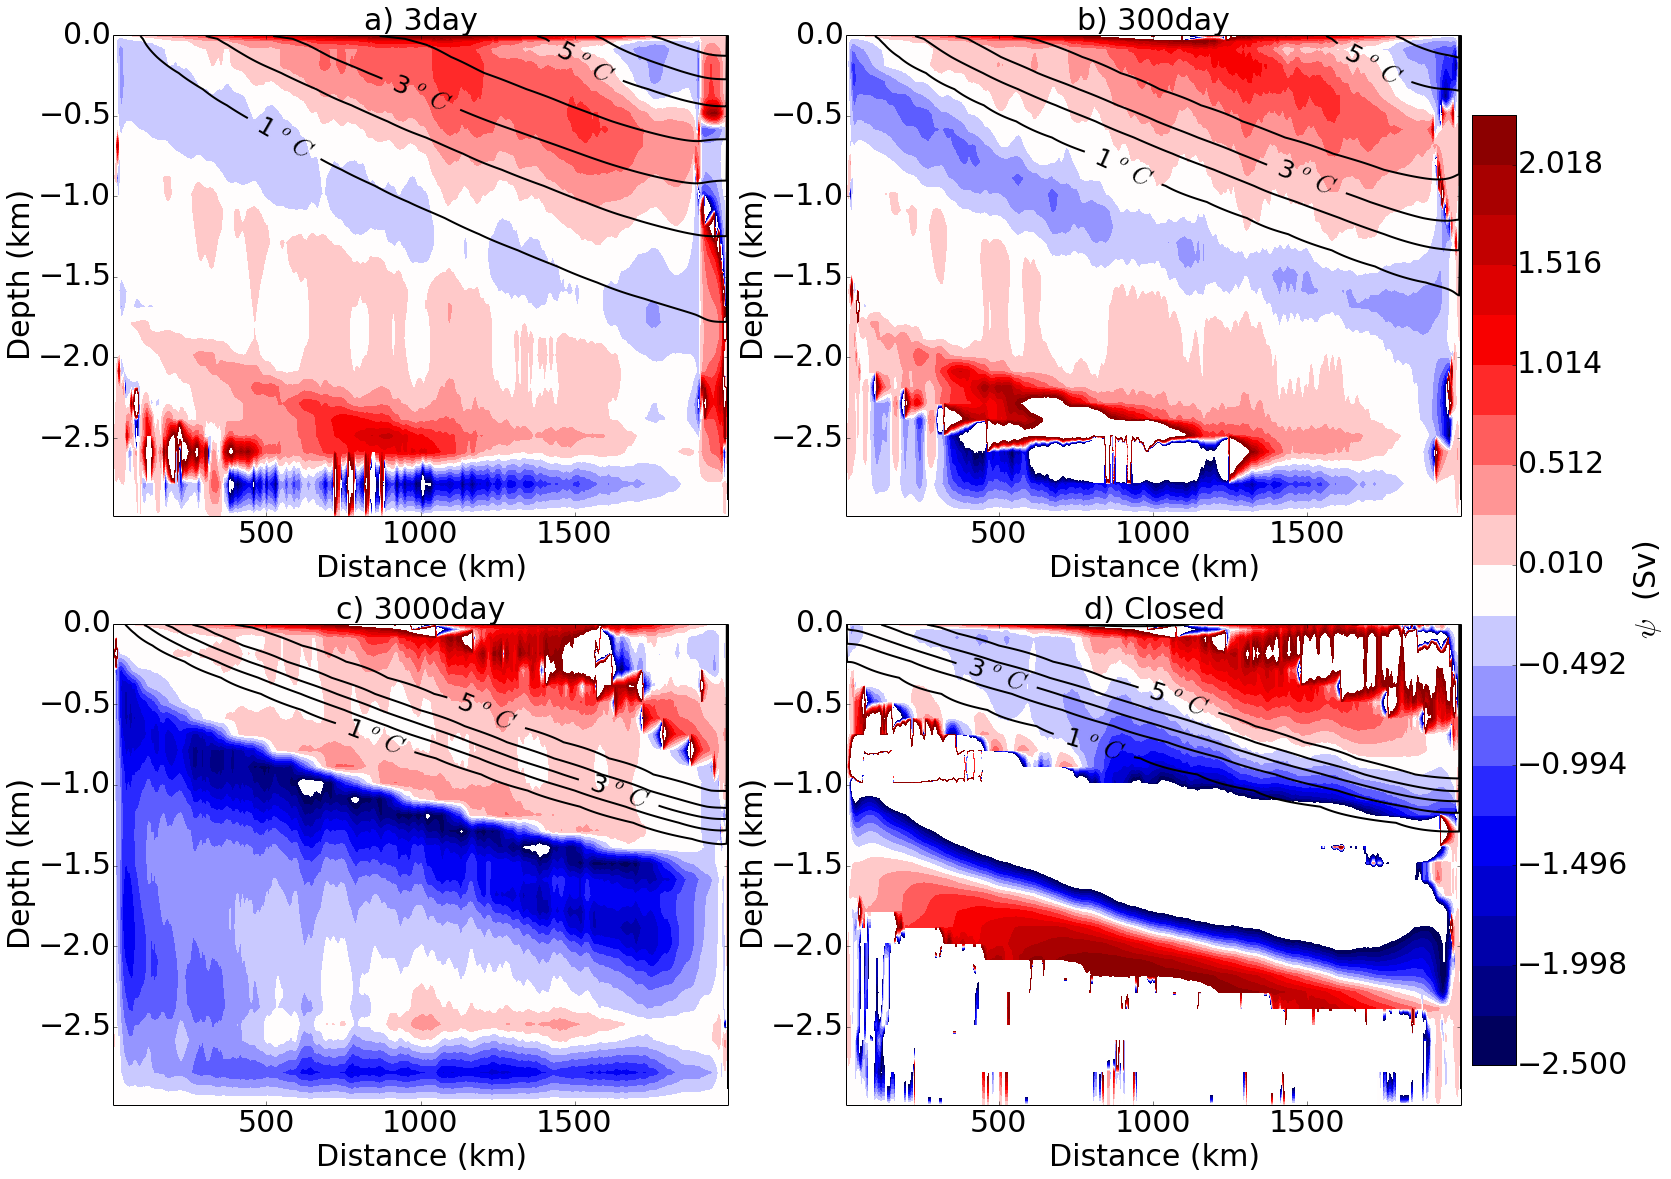

In [63]:
fig=plt.figure(figsize=(20.5,16.5))
for i in range(len(Runs)):
    fileWTprime = netCDF4.Dataset(path+'/'+str(tau[i])+'daynokpp/WTprimebar.nc','r')
    WTp = fileWTprime.variables['WT'][:].mean(axis=2)
    filetav = netCDF4.Dataset(path+'/'+str(tau[i])+'daynokpp/Tav.nc','r')
    VTav = filetav.variables['VVEL'][:].mean(axis=0)
    TTav = filetav.variables['THETA'][:].mean(axis=0)
    if str(tau[Runs[i]]) == 'Closed':
        tRef = [7.95797596, 7.81253554, 7.50931741, 6.93595077, 6.23538398,                
                5.60148493, 5.02790935, 4.5089167 , 4.03931274, 3.6143975 ,
                3.22991829, 2.88202712, 2.56724216, 2.28241296, 2.02468884,
                1.79149041, 1.58048375, 1.38955702, 1.21679938, 1.0604818 ,
                0.9190398 , 0.79105779, 0.67525488, 0.57047207, 0.47566066,
                0.38987176, 0.31224674, 0.24200873, 0.14898305, 0.04478574]
        TTav = np.apply_along_axis(np.divide, 0, TTav, 4-np.sum(tRef*dz)/-Z[-1])
    Tz, Ty = np.gradient(TTav.mean(axis=2))
    Tz = Tz/Zmatrix
    Ty = Ty/5000
    #Tz[TTav.mean(axis=2)<=.8]=np.nan
    #Ty[Ty<=0.000001]=np.nan
    PsiEd = -(WTp/Ty)
    Vstar = np.gradient(WTp/Ty)[0]/Zmatrix
    #Vres = hb.numba_regridy(VTav.mean(axis=2))+Vstar
    Vres = Vstar
    psi2 = hb.numba_regridy(VTav.sum(axis=2))*dx*Zmatrix
    psi = np.cumsum(-psi2[::-1, :], axis=0)
    npad = ((0, 1), (0, 0))
    # Pad with zeros at bottom
    psi = np.pad(psi, pad_width=npad, mode='constant',
                 constant_values=0)
    PsiEd = np.pad(PsiEd, pad_width=npad, mode='constant',
                 constant_values=0)
    y = Y/1000
    Psi = psi/10**6  # Convert to Sv
    Psi_levs = np.arange(-2.5, 2.5, .251)
    tylvls = np.arange(0.000 , 0.0001, 0.00001)*10**-1
    Psi_ticks =np.arange(0, 0.3, .5)
    Q2_levs = (np.arange(-1,8,1))
    ax = fig.add_subplot(2, 2, i+1)
    p = ax.contourf(Yc/1000, Zp/1000,
                       Psi+PsiEd, Psi_levs, cmap=plt.cm.seismic)
    #p = ax.contourf(Yc/1000, Z/1000, Ty ,tylvls, cmap=plt.cm.seismic)
    q = ax.contour(Yc/1000, Z/1000, TTav.mean(axis=2), Q2_levs, colors='k', linewidths=2)
    q.levels = [nf(val) for val in q.levels]
    plt.clabel(q, q.levels[::2], inline=1, fmt=fmt, fontsize=25)
    ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]])+'day', fontsize=30)
    if str(tau[Runs[i]]) == 'Closed':
        ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]]), fontsize=30)
    ax.set_xlabel('Distance (km)', fontsize=30)
    ax.set_ylabel('Depth (km)', fontsize=30)
    ax.tick_params(axis='both', which='major', labelsize=30)
plt.tight_layout()
q = (os.path.expanduser('~')+"/Figures/Mobilis")
if not os.path.exists(q):
    os.makedirs(q)
cax = fig.add_axes([1, 0.1, 0.03, 0.8])
cbar = fig.colorbar(p, cax=cax)
cbar.ax.set_ylabel('$\psi$  (Sv)', fontsize=30, )
cbar.ax.tick_params(labelsize=30)